<center>

<h1>  AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE </h1>
</center>

<hr>

## Resumen

En este paper se propone explorar el uso de arquitecturas self-atention, puntualmente la famosa transformer para tareas de clasificacion de imagenes. En este trabajo se define una nueva arquitectura de redes convolucionales fuertemente influenciada por la arquitectura original de Transformer.

## Vision Transformer (VIT)

La arquitectura Transformer recibe como entrada una secuencia $1D$ de embeddings de tokens. Para manipular imagenes $2D$ se redimenciona la imagen $x \in R^{H \times W \times C}$ en una secuencia plana de parches $2D$, es decir: $x_p \in R^{N \times (P^2 . C)}$, donde $(W, H)$ es la resolucion original de la imagen, $C$ es el numero de canales, $(P,P)$ es la resolucion de cada parche, y $N = \frac{HW}{P^2}$ es el numero de parches resultantes, la cual sirve como el largo de la secuencia para el Transformer. El Transformer usa vectores latentes de tamaño $D$ a traves de todas sus capas, por lo que cada parche plano debe mapearse un vector de $D$ dimensiones por medio de una proyeccion lineal:

$$ Z_0 = [x_\text{class}; x_p^1E; x_p^2E; ...; x_p^n E] + E_\text{pos} \qquad E \in R^{(P^2.C)\times D}, E_\text{pos}\in R^{(N+1) \times D}$$ 

Analogamente al token *[class]* de BERT, se antepone un embedding entrenable a la secuencia de embeddings de parches ($z_0^0 = x_\text{class}$), cuyo estado en la salida del encoder Transformer ($Z_L^0$) sirve como una representacion de la imagen. Es decir:

$$ y = LN(Z_L^0) $$

Al igual que en el trabajo original, se agregan embeddings posicionales para preservar la informacion posicional. Para ello se utiliza un embedding $1D$ entrenable (segun los autores no se observan beneficios de usar un embedding posicional $2D$). La secuencia resultante sirve como entrada para el encoder.

El encoder de un Transformer consiste de layers alternadas de *multihead self-attention* (MSA) y bloques *multi layer perceptron* (MLP). Luego de cada capa se aplica Layer Normalization (LN), y se producen conexiones residuales luego de cada bloque.

Cada bloque MLP consiste de dos layers con activacion GELU, es decir:

$$\begin{aligned}
    &z'_l = MSA(LN(z_{l-1})) + z_{l-1}, \qquad &l = 1...L\\
    &z_l = MLP(LN(z'_l)) + z'_l,        \qquad &l = 1...L
\end{aligned}$$

<hr>

## Imports

In [9]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers
from keras import ops
from utils import show_images, distribucion_labels
from typing import List

import numpy as np
import matplotlib.pyplot as plt

## Preparacion de los datos

In [2]:
NUM_CLASSES = 100 
INPUT_SHAPE = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
print(x_train.shape, x_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


## Visualizacion de las imagenes

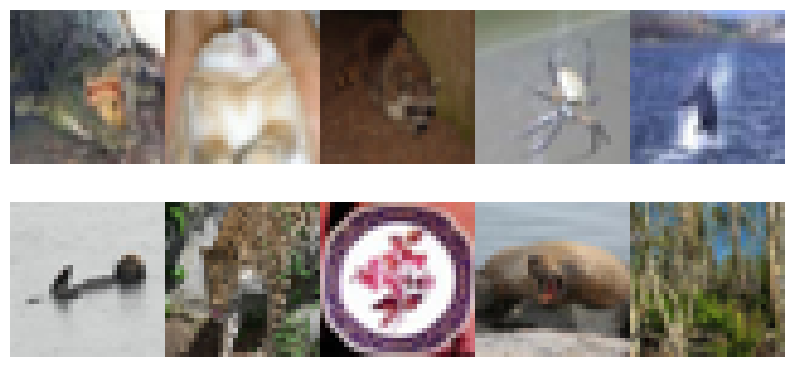

In [3]:
filas    = 2
columnas = 5
show_images(imgs=x_train, nrows=filas, ncolumns=columnas)

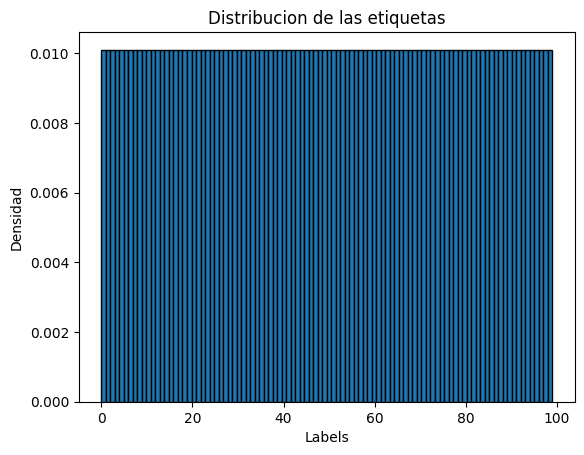

In [4]:
distribucion_labels(y_train)

# Hiperparametros

In [5]:
# Hiperparametros
learning_rate   = 0.001         # Parametro del optimizador   
weight_decay    = 0.0001        # Parametro del optimizador
batch_size      = 256           # Cantidad de imagenes por batch
epochs          = 10            # Cantidad de epocas de entrenamiento, 10 es un valor de prueba
image_size      = 72            # Redimensionaremos las imagenes de entrada a este tamaño
patch_size      = 6             # Tamaño de los parches
num_patches     = (image_size // patch_size) ** 2   # Cantidad de parches por imagen
projection_dim  = 64            # Dimension del embedding de los parches
num_heads       = 4             # Parametro del transformer
transformer_units = [           # Tamaños de las layers transformer
    projection_dim * 2,
    projection_dim,
]  
transformer_layers = 8          # Cantidad de layers transformer
mlp_head_units = [              # Cantidad de unidades por layer densa
    2048,
    1024,
]

## Data Augmentation

Entre los datos disponibles tenemos $60000$ imagenes distintas, esta cantidad puede no ser suficiente para la tarea en cuestion. La escazes de imagenes puede ocacionar overfitting en los modelos, para suplir esta carencia se suele realizar transformaciones que preserven la semantica de las imagenes, de este modo artificialmente podemos "crear imagenes nuevas" a partir de las existentes

In [6]:
# Definicion de la layer de augmentacion de datos
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),                                 # Aplica una normalizacion estandar sobre los pixeles
        layers.Resizing(image_size, image_size),                # Agrandamos la imagen (32, 32, 3) -> (72, 72, 3) 
        layers.RandomFlip("horizontal"),                        # Espejado horizontal aleatorio de la imagen 
        layers.RandomRotation(factor=0.02),                     # Rotacion aleatoria de la imagen 
        layers.RandomZoom(height_factor=0.2, width_factor=0.2)  # Zoom aleatorio de la imagen 
    ],
    name = "data_augmentation"
)

# Calculamos los parametros estadisticos para la normalizacion
data_augmentation.layers[0].adapt(x_train)

## Implementacion de las MLP (akka. layers densas o feedforward)

In [ ]:
def MLP(activations: List[float], hidden_units: List[int], dropout_rate: float) -> keras.Layer:
    """
    Construye un bloque de layers feedforward.
    Args:
        activations (List[float]):   Activaciones de la capa anterior.
        hidden_units (List[int]):    Cantidad de neuronas por cada layers intermedia.    
        dropout_rate (float):        Dropout entre layers.
    Returns:
        keras.Layer: Bloque de layers feedforward.
    """
    # TODO
    pass